In [159]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.fftpack import dct
import numpy as np
import os
import zipfile

In [ ]:
# Define data pre-processing functions 

# Import the mnist dataset 
def import_mnist_data(num_img):
    # Unzip the mnist data
    if not os.path.exists("mnist_dataset/"):
        if os.path.exists("mnist_dataset.zip"):
            with zipfile.ZipFile("mnist_dataset.zip", 'r') as zip_ref:
                zip_ref.extractall("mnist_dataset/")
        else:
            raise FileNotFoundError("mnist_dataset.zip not found.")
    # Load the mnist data
    # Ignore the first column of the data (the label)
    data = np.loadtxt("mnist_dataset/mnist_test.csv", delimiter=",", max_rows=num_img, usecols=range(1,785))
    data = data.reshape(num_img, 784)
    return data


# Sparsify the data by setting all values below a threshold to 0
def sparsify_data(data, threshold):
    sparse_data = np.copy(data)
    for i in range(sparse_data.shape[0]):
        for j in range(sparse_data.shape[1]):
            if sparse_data[i,j] < threshold: 
                sparse_data[i,j] = 0

    return sparse_data

# Generates a random measurement matrix with normalized columns
def make_meas_matrix(rows, cols):
    # Generate a matrix of numbers from the standard normal distribution
    meas_matrix = np.random.randn(rows, cols)
    # Normalize the columns of the matrix
    for i in range(cols):
        meas_matrix[:,i] = meas_matrix[:,i] / np.linalg.norm(meas_matrix[:,i])

    return meas_matrix



# Generate measurements from the data using the measurement matrix
def get_measurements(data, meas_matrix):
    return np.sign(meas_matrix @ data.T)

# Plot the original image and the estimated image
def plot_est_images(original_data, est_data):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original_data.reshape(28,28), cmap='gray', vmin=0, vmax=255)
    axs[0].set_title("Original Image")
    axs[1].imshow(est_data.reshape(28,28), cmap='gray', vmin=0, vmax=255)
    axs[1].set_title("Reconstructed Image")
    plt.show()

# def plot_algos(original_data, algo_output_data, reco_title="Reconstructed Image"):
#     fig, axs = plt.subplots(1, 2)
#     fig.set_figwidth(14)

#     axs[0].imshow(original_data.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
#     axs[0].set_title("Original Image")

#     axs[1].imshow(algo_output_data.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
#     axs[1].set_title(reco_title)

#     plt.tight_layout()
#     plt.show()

def plot_algos(data, titles):
    num_images = len(data)
    fig, axs = plt.subplots(1, num_images)
    fig.set_figwidth(14)
    for i in range(0,num_images):
        axs[i].imshow(data[i].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        axs[i].set_title(titles[i])
    
    plt.tight_layout()
    plt.show()


def plot_meas_matrix(meas_matrix):
    plt.imshow(meas_matrix, cmap='rainbow', vmin=-1, vmax=1)
    plt.title("Measurement Matrix")
    plt.show()

(1, 784)
(1, 784)


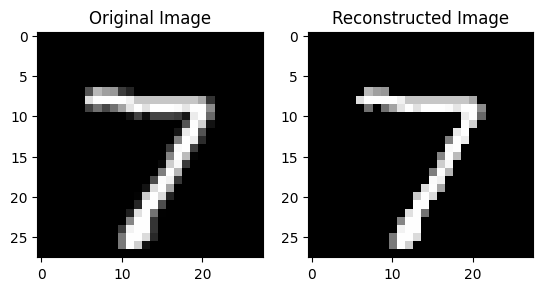

In [163]:
# Testing out data pre-processing functions

data = import_mnist_data(1)
print(data.shape)

sparse_data = sparsify_data(data, 100) #anything below 100 is = zero
print(sparse_data.shape)

plot_est_images(data, sparse_data)

meas_matrix = make_meas_matrix(200,784)
# plot_meas_matrix(meas_matrix[0:24,0:24])

measurement = get_measurements(sparse_data, meas_matrix)

**Helper Functions**

In [164]:
def get_k_support(v, k):
    w = np.copy(v)
    support = np.empty(0, dtype=int)
    for i in range(0, k):
        max_index = np.argmax(abs(w))
        support = np.append(support, max_index)
        w[max_index] = 0
    return support

def calculate_normalized_mse(original_data, est_data):
    return np.mean((original_data - est_data)**2) / np.mean(original_data**2)

def calculate_hamming_error(measurement, meas_matrix, est_data):
    return np.count_nonzero(measurement - np.sign(meas_matrix @ est_data))/measurement.shape[0]

def calculate_cosine_similarity(original_data, est_data):
    return (original_data.T @ est_data) / (np.linalg.norm(original_data) * np.linalg.norm(est_data))

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

**One-bit compressed sensing reconstruction algorithms**

***BIHT and RFPI***

In [ ]:

# https://link.springer.com/article/10.1007/s11704-017-6132-7?utm_source=chatgpt.com
# https://arxiv.org/pdf/2207.03427
# Binary Iterative Hard Thresholding - assumes we know the sparsity level
# Find a way to dynamically estimate the sparsity
def biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter):

    estimate = np.zeros((meas_matrix.shape[1], 1))
    convergence = []

    iter = 0
    delta = np.linalg.norm(measurement)
    while iter < max_iter and delta > threshold:
        partial_f = (lamda/2) * meas_matrix.T @ (np.sign(measurement) - np.sign(meas_matrix @ estimate))
        last_estimate = estimate
        estimate = estimate + step_size * partial_f
        
        # Hard thresholding
        support = get_k_support(estimate, sparsity)
        temp = np.zeros((meas_matrix.shape[1], 1))
        temp[support,:] = estimate[support,:]
        estimate = temp

        delta = np.linalg.norm(estimate - last_estimate)
        convergence.append(delta)

        iter += 1
    return estimate, convergence

# https://publications.lib.chalmers.se/records/fulltext/164371/local_164371.pdf
# RFPI - Regularized Fixed Point Iteration
def rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter):

    estimate = np.linalg.pinv(meas_matrix) @ measurement
    Y = np.diagflat(measurement)
    iter = 0
    convergence = []

    delta = np.linalg.norm(measurement)
    while iter < max_iter and delta > threshold:
        last_estimate = estimate
        s = (Y @ meas_matrix).T @ np.maximum(np.multiply(measurement, meas_matrix @ estimate), np.zeros_like(measurement))
        g = s - (s.T @ estimate) * estimate 
        h = estimate - step_size * g
        estimate = soft_thresholding(h, step_size/lamda)
        estimate /= np.linalg.norm(estimate)
        iter += 1

        delta = np.linalg.norm(estimate - last_estimate)
        convergence.append(delta)
    return estimate, convergence
    


**ONE BIT OMP**

In [197]:
def one_bit_omp(meas_matrix, measurement, sparsity, max_iter=None, known_sparsity=True):
    m, n = meas_matrix.shape
    if max_iter is None:
        max_iter = sparsity

    residual = measurement.copy()
    res_norm = np.linalg.norm(residual)

    support = []
    estimate = np.zeros(n)
    convergence = []

    for it in range(max_iter):
        if len(support) >= sparsity:
            break

        correlations = meas_matrix.T @ residual
        correlations[support] = 0.0  # Mask already selected atoms

        i = np.argmax(np.abs(correlations))
        if i in support:
            continue

        support.append(i)

        # Estimate signal
        A_support = meas_matrix[:, support]
        x_support = np.linalg.pinv(A_support) @ measurement
        estimate = np.zeros(n)
        estimate[support] = x_support

        # If the new residual is smaller than the last residual, increase the sparsity
        if known_sparsity == False:
            if (np.linalg.norm(measurement - np.sign(meas_matrix @ estimate)) < res_norm):
                sparsity += 1

        # Compute residual and convergence metric
        residual = measurement - np.sign(meas_matrix @ estimate)
        res_norm = np.linalg.norm(residual)
        convergence.append(res_norm)

        if np.all(residual == 0):
            break

    return estimate, convergence


***MSP***

In [166]:
#MSP algorithm (fixed)
def msp(meas_matrix, measurement, sparsity, max_iters=1000):
    m, n = meas_matrix.shape
    estimate = np.zeros(n)
    residual = measurement.copy()
    support_set = set()
    convergence = []

    for it in range(max_iters):
        correlations = meas_matrix.T @ residual
        # Zero out already selected atoms
        for idx in support_set:
            correlations[idx] = 0.0

        i = np.argmax(np.abs(correlations))
        support_set.add(i)

        estimate[i] += correlations[i]

        if len(support_set) > sparsity:
            estimate = hard_threshold(estimate, sparsity)
            support_set = set(np.flatnonzero(estimate)) #enforce sparsity

        residual = measurement - np.sign(meas_matrix @ estimate)
        res_norm = np.linalg.norm(residual)
        convergence.append(res_norm)

        if np.all(residual == 0):
            break

    support = np.flatnonzero(estimate)
    return estimate, convergence

def hard_threshold(x, k):
    if k >= len(x):
        return x.copy()
    indices = np.argpartition(np.abs(x), -k)[-k:]
    x_thresh = np.zeros_like(x)
    x_thresh[indices] = x[indices]
    return x_thresh

**CVX**

In [167]:
import cvxpy as cp

def convex_l1_sign(meas_matrix, measurement, max_iters=1000):
    """
        convergence: Dummy list since CVXPY does not provide step-wise info.
    """
    m, n = meas_matrix.shape
    x = cp.Variable(n)
    
    # Sign consistency constraints: y_i * (A x)_i >= 1
    constraints = [cp.multiply(measurement, meas_matrix @ x) >= 1]
    objective = cp.Minimize(cp.norm1(x))
    problem = cp.Problem(objective, constraints)
    
    problem.solve(solver=cp.SCS, max_iters=max_iters)
    
    estimate = x.value
    if estimate is None:
        estimate = np.zeros(n)  # fallback 
    
    convergence = []  # placeholder for plotting consistency
    return estimate, convergence


**Helper function test_algo to test our algorithms on multiple images and measurement matrices**

In [193]:
# Loop to test algorithms on multiple images
def test_algo(algo, num_images, sparse_data, measurement_dims, step_size, lamda, sparsity, known_sparsity, threshold, max_iter):

    mses = []
    hamming_errors = [] 
    cosine_sims = []

    for m in measurement_dims:
        mse_dim = []
        hamming_error_dim = []
        cosine_sim_dim = []
        for idx in range(0,num_images):
            curr_data = sparse_data[idx,:]
            meas_matrix = make_meas_matrix(m,784)
            measurement = np.reshape(get_measurements(curr_data, meas_matrix), (m,1))

            if (algo == "rfpi"):
                estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
            elif (algo == "biht"):
                estimate, convergence = biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter)
            elif (algo=='one_bit_omp'):
                estimate, convergence=one_bit_omp(meas_matrix, measurement.flatten(), sparsity, max_iter, known_sparsity)
            elif(algo=='msp'):
                estimate, convergence=msp(meas_matrix, measurement.flatten(), sparsity, max_iter)
            elif(algo=='inbuilt_solver'):
                estimate,convergence=convex_l1_sign(meas_matrix, measurement.flatten(), max_iters=1000)


            # Zero-out negative values - these are erroneous
            estimate[estimate < 0] = 0
            # Renormalize
            estimate = estimate * 255/(np.max(estimate))
            
            hamming_error = calculate_hamming_error(measurement, meas_matrix, estimate)
            hamming_error_dim.append(hamming_error)
            mse = calculate_normalized_mse(curr_data, estimate)
            mse_dim.append(mse)
            cosine_sim = calculate_cosine_similarity(curr_data, estimate)
            cosine_sim_dim.append(cosine_sim)

        mses.append(np.mean(mse_dim))
        hamming_errors.append(np.mean(hamming_error_dim))
        cosine_sims.append(np.mean(cosine_sim_dim))

    return cosine_sims, mses, hamming_errors, curr_data, estimate, convergence

**TEST AND COMPARE ALGOS**

/Users/josephineking/Desktop/School/Data Compression/EE4740_ImageCompression/img_comp_env/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


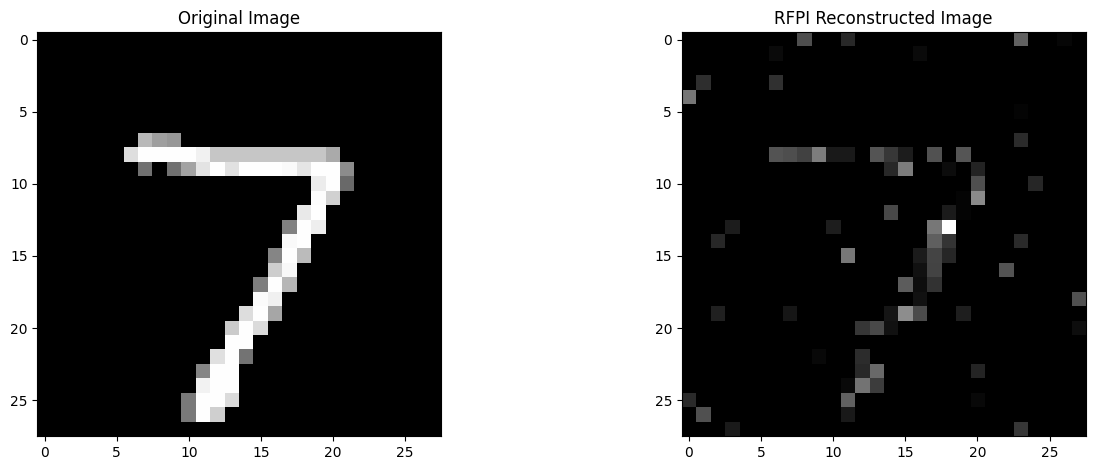

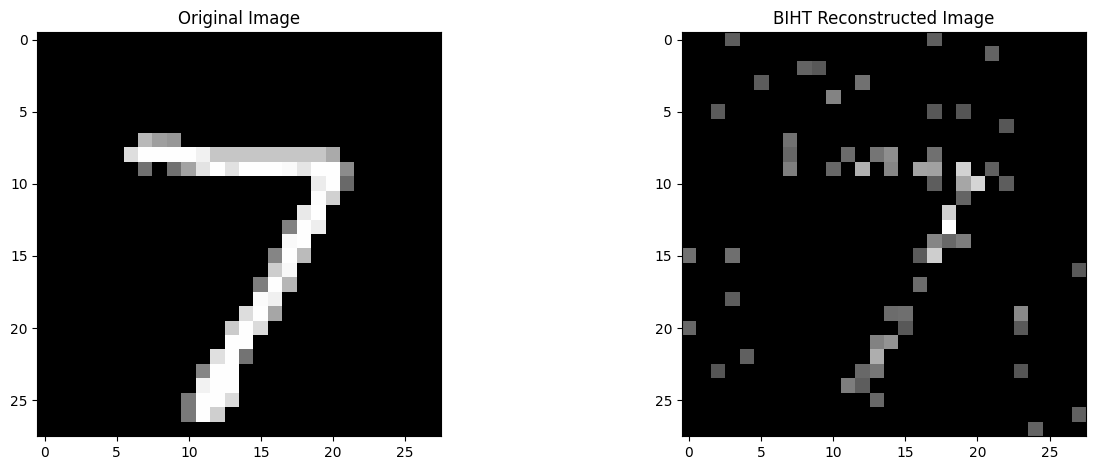

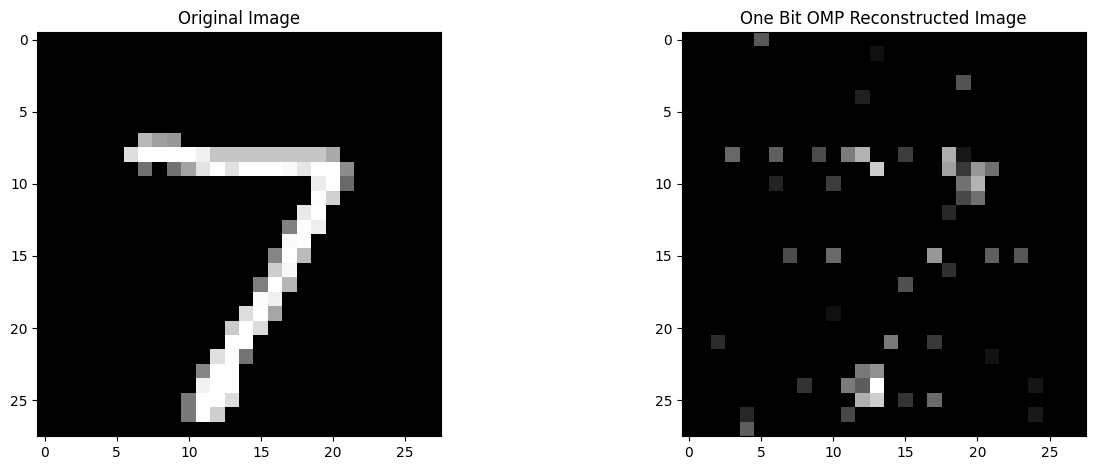

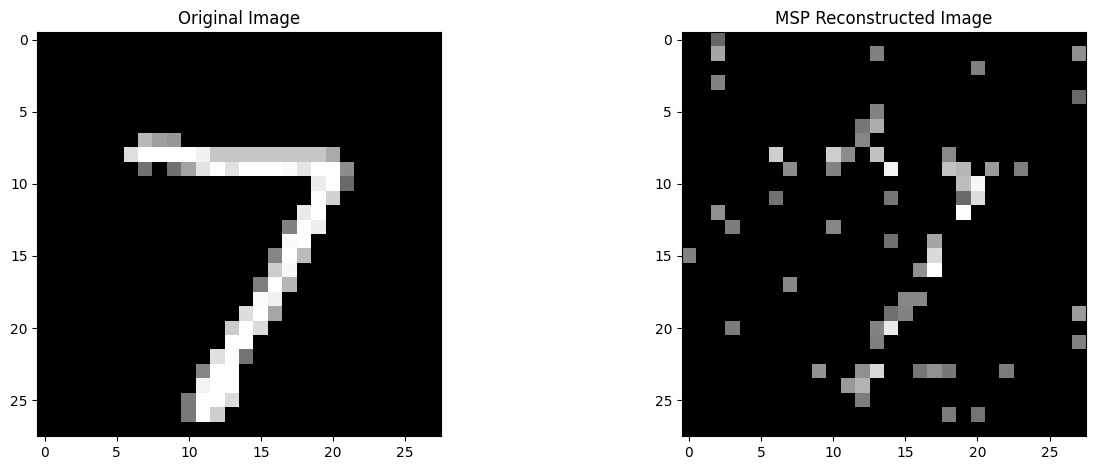

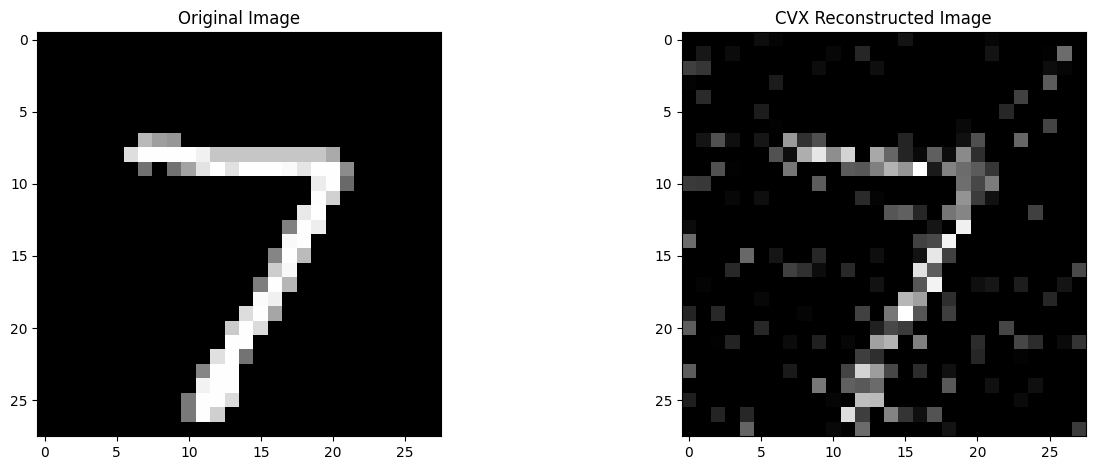

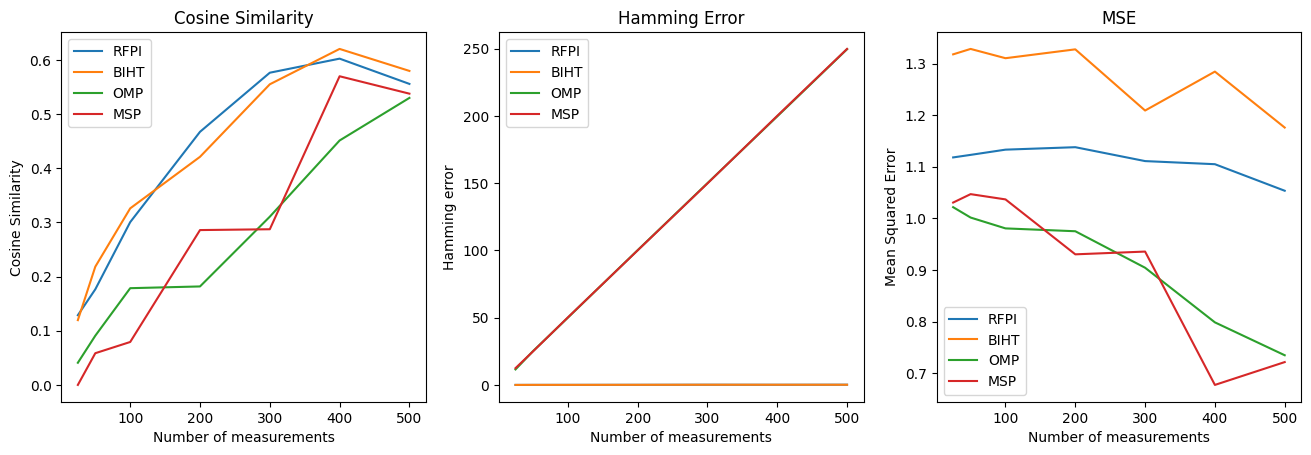

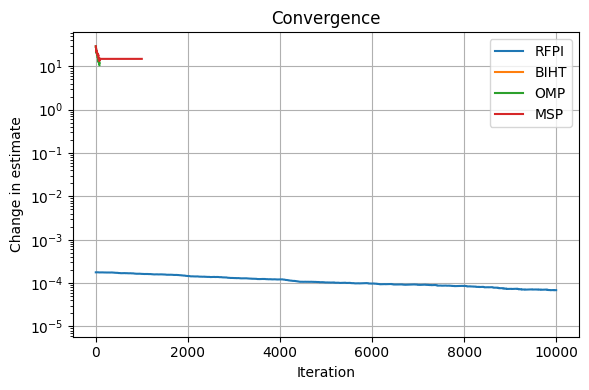

In [194]:
meas_matrix_dims = [25,50,100,200,300,400,500]
num_img = 1
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 100)

cosine_sim_omp, mses_omp, hamming_errors_omp, curr_data, estimate_omp, convergence_omp = test_algo("one_bit_omp", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-3, 1000)
cosine_sim_rfpi, mses_rfpi, hamming_errors_rfpi, curr_data, estimate_rfpi, convergence_rfpi = test_algo("rfpi", num_img, sparse_data, meas_matrix_dims, 1e-4, 10, 0, False, 1e-5, 10000)
cosine_sim_biht, mses_biht, hamming_errors_biht, curr_data, estimate_biht, convergence_biht = test_algo("biht", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-3, 1000)
cosine_sim_msp, mses_msp, hamming_errors_msp, curr_data, estimate_msp, convergence_msp = test_algo("msp", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-3, 1000)
cosine_sim_cvx, mses_cvx, hamming_errors_cvx, curr_data, estimate_cvx, convergence_cvx = test_algo("inbuilt_solver", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-3, 1000)

plot_algos(curr_data, estimate_rfpi, "RFPI Reconstructed Image")
plot_algos(curr_data, estimate_biht, "BIHT Reconstructed Image")
plot_algos(curr_data, estimate_omp, "One Bit OMP Reconstructed Image")
plot_algos(curr_data, estimate_msp, "MSP Reconstructed Image")
plot_algos(curr_data, estimate_cvx, "CVX Reconstructed Image")


fig, axs = plt.subplots(1, 3)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims, cosine_sim_rfpi)
axs[0].plot(meas_matrix_dims, cosine_sim_biht)
axs[0].plot(meas_matrix_dims,cosine_sim_omp)
axs[0].plot(meas_matrix_dims,cosine_sim_msp)
axs[0].set_title("Cosine Similarity")
axs[0].set_xlabel("Number of measurements")
axs[0].set_ylabel("Cosine Similarity")
axs[0].legend(["RFPI", "BIHT","OMP","MSP"])
axs[1].plot(meas_matrix_dims, hamming_errors_rfpi)
axs[1].plot(meas_matrix_dims, hamming_errors_biht)
axs[1].plot(meas_matrix_dims,hamming_errors_omp)
axs[1].plot(meas_matrix_dims,hamming_errors_msp)
axs[1].set_title("Hamming Error")
axs[1].set_xlabel("Number of measurements")
axs[1].set_ylabel("Hamming error")
axs[1].legend(["RFPI", "BIHT","OMP","MSP"])
axs[2].plot(meas_matrix_dims, mses_rfpi)
axs[2].plot(meas_matrix_dims, mses_biht)
axs[2].plot(meas_matrix_dims,mses_omp)
axs[2].plot(meas_matrix_dims,mses_msp)
axs[2].set_title("MSE")
axs[2].set_xlabel("Number of measurements")
axs[2].set_ylabel("Mean Squared Error")
axs[2].legend(["RFPI", "BIHT","OMP","MSP"])
plt.show()

plt.figure(figsize=(6, 4))
plt.semilogy(convergence_rfpi)
plt.semilogy(convergence_biht)
plt.semilogy(convergence_omp)
plt.semilogy(convergence_msp)
plt.xlabel("Iteration")
plt.ylabel("Change in estimate")
plt.title("Convergence")
plt.legend(["RFPI", "BIHT","OMP", "MSP"])
plt.grid(True)
plt.tight_layout()
plt.show()


**Test OMP and RFPI** Now that we've chosen these two algorithms, we focus our attention on these two

3


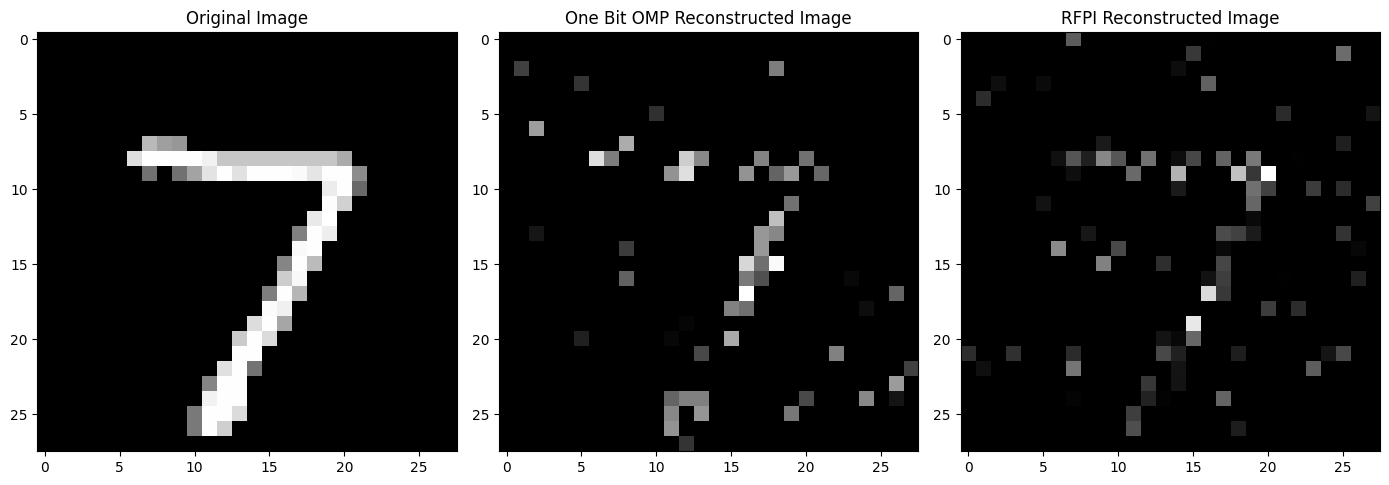

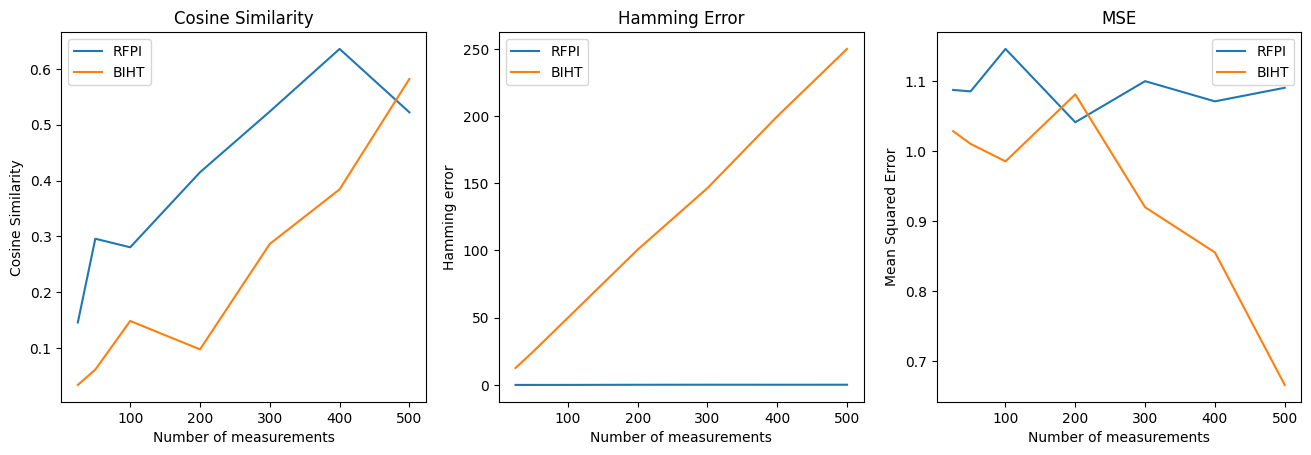

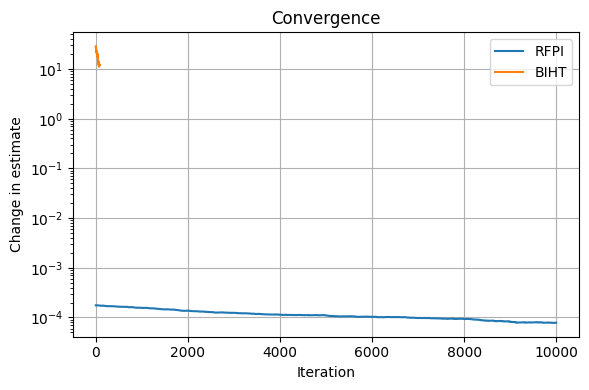

In [ ]:
meas_matrix_dims = [25,50,100,200,300,400,500]
num_img = 1
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 100)

cosine_sim_omp, mses_omp, hamming_errors_omp, curr_data, estimate_omp, convergence_omp = test_algo("one_bit_omp", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, True, 1e-3, 1000)
cosine_sim_omp_us, mses_omp_us, hamming_errors_omp_us, curr_data, estimate_omp_us, convergence_omp_us = test_algo("one_bit_omp", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 10, False, 1e-3, 1000)
cosine_sim_rfpi, mses_rfpi, hamming_errors_rfpi, curr_data, estimate_rfpi, convergence_rfpi = test_algo("rfpi", num_img, sparse_data, meas_matrix_dims, 1e-4, 10, 0, False, 1e-5, 10000)

plot_algos([curr_data, estimate_rfpi, estimate_omp, estimate_omp_us], ["Original Image", "One Bit OMP Reconstructed Image", "RFPI Reconstructed Image"])

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims, cosine_sim_rfpi)
axs[0].plot(meas_matrix_dims,cosine_sim_omp)
axs[0].plot(meas_matrix_dims,cosine_sim_omp_us)
axs[0].set_title("Cosine Similarity")
axs[0].set_xlabel("Number of measurements")
axs[0].set_ylabel("Cosine similarity")
axs[0].legend(["RFPI","OMP","OMP Unknown Sparsity"])
axs[1].plot(meas_matrix_dims, hamming_errors_rfpi)
axs[1].plot(meas_matrix_dims,hamming_errors_omp)
axs[1].plot(meas_matrix_dims,hamming_errors_omp_us)
axs[1].set_title("Hamming Error")
axs[1].set_xlabel("Number of measurements")
axs[1].set_ylabel("Hamming error")
axs[1].legend(["RFPI","OMP","OMP Unknown Sparsity"])
axs[2].plot(meas_matrix_dims, mses_rfpi)
axs[2].plot(meas_matrix_dims,mses_omp)
axs[2].plot(meas_matrix_dims,mses_omp_us)
axs[2].set_title("MSE")
axs[2].set_xlabel("Number of measurements")
axs[2].set_ylabel("Mean Squared Error")
axs[2].legend(["RFPI","OMP","OMP Unknown Sparsity"])
plt.show()

plt.figure(figsize=(6, 4))
plt.semilogy(convergence_rfpi)
plt.semilogy(convergence_omp)
plt.semilogy(convergence_omp_us)
plt.xlabel("Iteration")
plt.ylabel("Change in estimate")
plt.title("Convergence")
plt.legend(["RFPI","OMP","OMP Unknown Sparsity"])
plt.grid(True)
plt.tight_layout()
plt.show()